# Exercise 2 - Recurrent Neural Networks for Sequential Data Analysis - Energy Consumption Forecasting

In this tutorial we will conduct energy consumption forecasting using a Recurrent Neural Network.

**Dataset:**
The  dataset is from the La Trobe University Energy Analytics Platform (LEAP), the Net Zero initiative at La Trobe. The dataset contains energy consumption
readings (MeterReading column) of a teaching building at 1-hour time intervals.

## Load Libraries

Load required libraries for modeling and data processing

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint
from matplotlib.dates import DateFormatter
%matplotlib inline

## Load data from google drive

Libraries to load data from google drive shared location.

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the python document (PyDrive) client.

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [4]:
dataset_file_id = '1X42C-CLgn06m5c4NksutyKe87jZseFNk'

Download the dataset file.

In [5]:
downloaded = drive.CreateFile({'id':dataset_file_id}) 
downloaded.GetContentFile('building_type_teaching_ts.csv')  

Load the dataset file to a dataframe using Pandas library.

In [6]:
df = pd.read_csv('building_type_teaching_ts.csv', index_col=0)

Explore the dataset.

In [7]:
df.head(10)

,MeterReading
Timestamp,
2018-01-01 00:00:00,21.532
2018-01-01 01:00:00,28.625
2018-01-01 02:00:00,28.937
2018-01-01 03:00:00,28.688
2018-01-01 04:00:00,29.531
2018-01-01 05:00:00,28.875
2018-01-01 06:00:00,27.562
2018-01-01 07:00:00,50.437
2018-01-01 08:00:00,57.656


Dataset contains 2 column:  


1.   Timestamp
2.   MeterReading (Our predictor)



## Preprocessing

We will conduct 2 pre-processing steps for this dataset,  
1. Normalize the dataset  
2. Format the dataset to adapt recurrent learning.

### Standardization

Copy the index (i.e., actual time frame) for evaluation and visualization purposes.

In [8]:
date_times = df.index.values

Load features from the dataframe, and normalize between 0-1.  
This scaler *object* is the min max scaler, which can be used to inverse the scale after prediction.

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))

Scale the dataset using the min-max scaler object.

In [10]:
values = df.values.astype('float32')
scaled_values = scaler.fit_transform(values)

### Format to adapt recurrent learning

Define how many time intervals is required/used to predict the energy consumption.
* For this experiment, we take 6 hours of previous energy consumption (i.e., six 1-hour intervals) - used as *n_1hour_interval*  
* Define the number of feature columns in order to construct data records combining sequence of *n_1hour_interval* s 

In [11]:
n_1hour_interval = 6
n_features = df.shape[1]

The following function will enable to construct input records capturing more than 1 hour of input time steps.  
This is one of the most important pre-processing steps to use Backpropagation through time by recurrent neural networks when learning sequence predictions problems.

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
df_reframed = series_to_supervised(scaled_values, n_1hour_interval, 1)

In [14]:
df_reframed.head()

,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
6,0.206663,0.274741,0.277736,0.275346,0.283437,0.277141,0.264538
7,0.274741,0.277736,0.275346,0.283437,0.277141,0.264538,0.484091
8,0.277736,0.275346,0.283437,0.277141,0.264538,0.484091,0.553379
9,0.275346,0.283437,0.277141,0.264538,0.484091,0.553379,0.552784
10,0.283437,0.277141,0.264538,0.484091,0.553379,0.552784,0.554886


### Train-Test split

Split the dataset into train set and test set.  
First *n_obs* parametarized number of feature columns in the dataset. 

In [15]:
n_obs = n_1hour_interval * n_features
n_obs

6

For this experiment we use 70/30 train/test split.

In [16]:
n_train_records = int(len(df_reframed.values) * .7) 
n_train_records

6127

Split the dataset for training and testing.



In [17]:
train = df_reframed.values[:n_train_records, :]
test = df_reframed.values[n_train_records:, :]
test_date_times = date_times[n_train_records:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (6127, 7)
Test shape: (2627, 7)


Construct X set as the features and Y set as the predictor/ or the output variable.

In [18]:
X_train, y_train = train[:, :n_obs], train[:, -1]  
X_test, y_test = test[:, :n_obs], test[:, -1]
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('\nX_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6127, 6)
y_train shape: (6127,)

X_test shape: (2627, 6)
y_test shape: (2627,)


The inputs (X) are reshaped into the 3D format expected by RNN, namely (samples, timesteps, features).

In [19]:
X_train = X_train.reshape((X_train.shape[0], n_1hour_interval, n_features))
X_test = X_test.reshape((X_test.shape[0], n_1hour_interval, n_features))
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (6127, 6, 1)
X_test shape: (2627, 6, 1)


## Modelling

We design a RNN based on hierarchically stacked three layered LSTM network architecture that consists of 32, 24 and 12 LSTM Networks respectively, accommodating deeper abstraction of temporal hierarchy to be trained by the forecasting model.

Model design:

In [20]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(24, return_sequences=True))
model.add(LSTM(12))
model.add(Dense(1))

Compile the model with [Mean Squarred Error](https://keras.io/losses/) loss functions and [ADAM optimizer](https://keras.io/optimizers/).

In [21]:
model.compile(loss='mse', optimizer='adam')

Train the model with parameters;  
*   Train epochs: 50
*   Batch size: 32
*   Use 0.3 from the training dataset as model validation data.



In [22]:
train_epochs = 50
batch_size = 32
validation_split = 0.3
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, validation_split=validation_split, verbose=1, shuffle=False)

Epoch 1/50
134/134 [==============================] - 10s 15ms/step - loss: 0.0576 - val_loss: 0.0370
Epoch 2/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0342 - val_loss: 0.0287
Epoch 3/50
134/134 [==============================] - 1s 9ms/step - loss: 0.0163 - val_loss: 0.0084
Epoch 4/50
134/134 [==============================] - 1s 8ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 5/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 6/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 7/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 8/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 9/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 10/50
134/134 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.00

Visualize the learning curve.

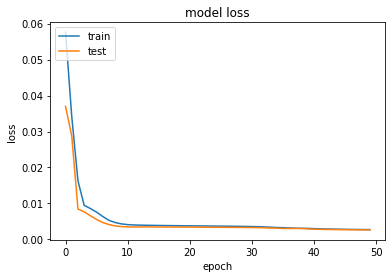

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Evaluation

Make predictions using the trained RNN model for the X_test (test dataset.)

In [24]:
yhat = model.predict(X_test, batch_size=batch_size)
yhat.shape

(2627, 1)

Reshape the test dataset for calculations. (From 3D to 2D)

In [25]:
X_test = X_test.reshape((X_test.shape[0], n_1hour_interval * n_features))
X_test.shape

(2627, 6)

Evaluate the accuracy using root mean square error (RMSE)

In [26]:
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)
rmse

0.053527668

Rescale the predictions using the min-max scaler object.

In [27]:
inv_yhat = np.concatenate((yhat, X_test[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

Rescale the test data (y_test) using the min-max scaler object.

In [28]:
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

Setup plot axes for prediction plot.

In [29]:
x_axis_labels = list(map(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'), test_date_times[n_1hour_interval:]))

Plot the forecast with respect to actual energy consumption.

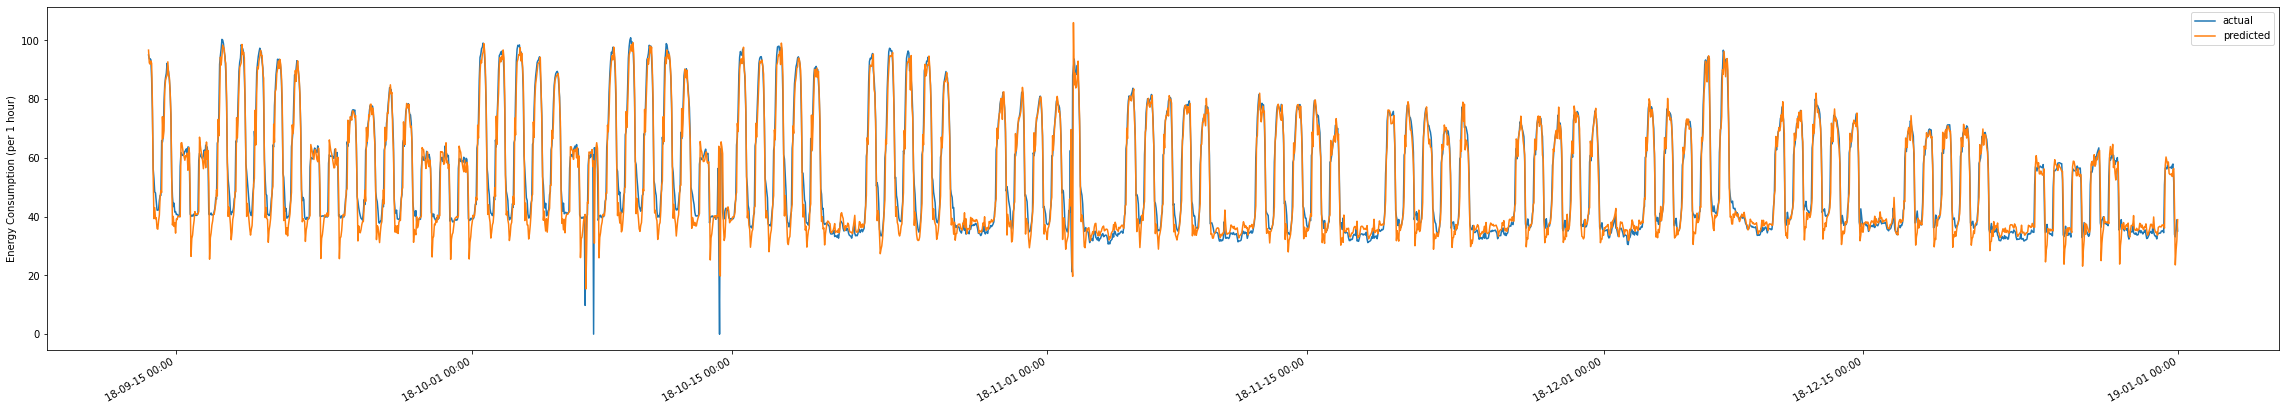

In [30]:
fig,ax = plt.subplots(figsize=(40,7))
ax.plot(x_axis_labels, inv_y, label='actual')
ax.plot(x_axis_labels, inv_yhat, label='predicted')
date_formatter = DateFormatter('%y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('Energy Consumption (per 1 hour)')
plt.show()